# Machine Learning from Disaster

https://www.kaggle.com/competitions/titanic/data?select=train.csv

predict which passengers survived the titanic shipwreck

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew

from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
from sklearn.svm import SVC




from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense

from sklearn.tree import export_graphviz
import pydot

In [70]:
df_test = pd.read_csv('./test.csv')
df_train = pd.read_csv('./train.csv')

- passengerid: increment id

- survived: predict value; 0 = No, 1 = Yes

- Pclass: ticket class

- Age : age in years, so must int.
- SibSp: # of siblings / spouses aboard the Titanic	
- Parch: # of parents / children aboard the Titanic	
- Fare: Passenger fare
- Cabin: Cabin number
- Embarked : Port of Embarkation

In [71]:
df_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


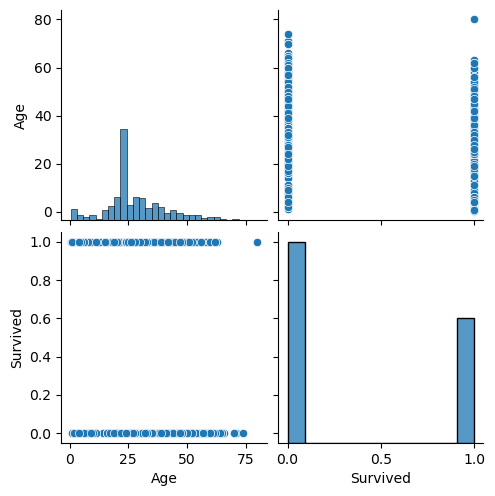


 ---- train set ----

 ---- describe ----
count    891.000000
mean      28.566970
std       13.199572
min        0.420000
25%       22.000000
50%       24.000000
75%       35.000000
max       80.000000
Name: Age, dtype: float64



 ---- value_counts ----
24.00    207
22.00     27
18.00     26
28.00     25
30.00     25
        ... 
36.50      1
55.50      1
0.92       1
23.50      1
74.00      1
Name: Age, Length: 88, dtype: int64



 ---- group by y ----
Age
0.42     1.0
0.67     1.0
0.75     1.0
0.83     1.0
0.92     1.0
        ... 
70.00    0.0
70.50    0.0
71.00    0.0
74.00    0.0
80.00    1.0
Name: Survived, Length: 88, dtype: float64



 ---- skewed ----
0.6566450606274806

 ---- test set ----

 ---- describe ----
count    418.000000
mean      28.982057
std       12.887063
min        0.170000
25%       23.000000
50%       24.000000
75%       35.750000
max       76.000000
Name: Age, dtype: float64



 ---- value_counts ----
24.0    103
21.0     17
22.0     16
30.0     15
18.0   

In [106]:
#examine every feature in train and test data
def feature_desc(feature):
    sns.pairplot(df_train[[feature,'Survived']])
    plt.show()
    
    print('\n ---- train set ----')
    print('\n ---- describe ----')
    print(df_train[feature].describe())
    print('\n')
    print('\n ---- value_counts ----')
    print(df_train[feature].value_counts(dropna=False))
    print('\n')
    print('\n ---- group by y ----')
    print(df_train.groupby(feature)['Survived'].mean())
    print('\n')
    print('\n ---- skewed ----')
    if df_train[feature].dtype != 'O':
        print(skew(df_train[feature]))    
    
    print('\n ---- test set ----')
    print('\n ---- describe ----')
    print(df_test[feature].describe())
    print('\n')
    print('\n ---- value_counts ----')
    print(df_test[feature].value_counts(dropna=False))
    print('\n')
    print('\n ---- skewed ----')
    if df_test[feature].dtype != 'O':
        print(skew(df_test[feature]))


    #shows values only in test
    
    print('\n')
    print('\n ---- only in test ----')
    print(set(df_test[feature])-set(df_test[feature]))
feature_desc('Age')

# pre-processing

In [73]:
# convert set to 0 and 1

sex_dict = {
    'male':0,
    'female':1
}

df_train['Sex'].replace(sex_dict,inplace = True)
df_test['Sex'].replace(sex_dict,inplace = True)

In [74]:
# fill age na with most frequent value : 24
df_train['Age'] = df_train['Age'].fillna(24)
df_test['Age'] = df_test['Age'].fillna(24)

In [75]:
# fill fare = 0 with class average fare.

class_avg_fare = df_train.groupby('Pclass')['Fare'].mean()
df_train.loc[df_train['Fare']==0,'Fare'] = df_train.loc[df_train['Fare']==0,'Pclass'].map(class_avg_fare)
df_test.loc[df_test['Fare']==0,'Fare'] = df_test.loc[df_test['Fare']==0,'Pclass'].map(class_avg_fare)

#df_test 1 na
df_test.loc[df_test['Fare'].isna(),'Fare'] = df_test.loc[df_test['Fare'].isna(),'Pclass'].map(class_avg_fare)


In [76]:
# cabin, na as a type; and extract abc.. cabin information as categorical feature
df_train['Cabin'] = df_train['Cabin'].fillna("None")
df_test['Cabin'] = df_test['Cabin'].fillna("None")

df_train['Cabin_N'] = df_train['Cabin'].str.get(0)
df_test['Cabin_N'] = df_test['Cabin'].str.get(0)

df_train['Cabin_N'] = df_train['Cabin_N'].replace('T','N')


In [77]:
# embark
df_train['Embarked'] = df_train['Embarked'].fillna("S")
df_test['Embarked'] = df_test['Embarked'].fillna("S")


In [78]:
#drop irrelevent columns
drop_columns = ['PassengerId','Name','Ticket','Cabin']

df_train.drop(columns =drop_columns, inplace=True )
df_test.drop(columns =drop_columns, inplace=True )

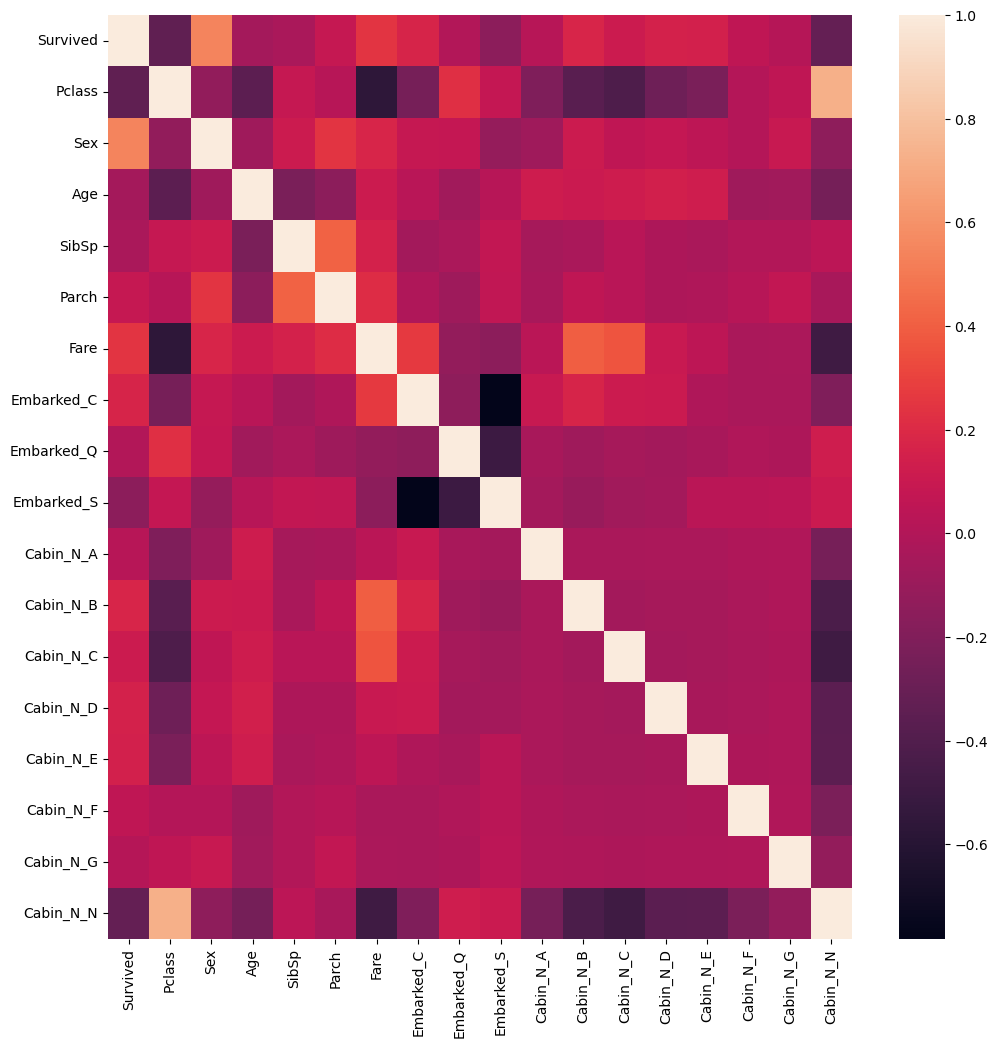

In [119]:
corrmat = df_train.corr()
plt.subplots(figsize = (12,12))
sns.heatmap(corrmat)
plt.show()

# one hot encoding

In [79]:
categorical_columns = ['Cabin_N','Embarked']
category_analysis = pd.DataFrame(categorical_columns, columns = ['Feature'])
unique_values = []
unique_counts = []

for i in categorical_columns:
    unique_values.append(df_train[i].unique())
    unique_counts.append(len(df_train[i].unique()))
    
category_analysis["Categories"] = unique_values
category_analysis["Number"] = unique_counts
category_analysis

,Feature,Categories,Number
0,Cabin_N,"[N, C, E, G, D, A, B, F]",8
1,Embarked,"[S, C, Q]",3


In [80]:
#convert categorical variables into one hot encode

df_train = pd.get_dummies(df_train)
df_test = pd.get_dummies(df_test)

#df_train.to_excel('./res.xlsx')

In [81]:
# now skip log temperary
df_train

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Cabin_N_A,Cabin_N_B,Cabin_N_C,Cabin_N_D,Cabin_N_E,Cabin_N_F,Cabin_N_G,Cabin_N_N
0,0,3,0,22.0,1,0,7.2500,0,0,1,0,0,0,0,0,0,0,1
1,1,1,1,38.0,1,0,71.2833,1,0,0,0,0,1,0,0,0,0,0
2,1,3,1,26.0,0,0,7.9250,0,0,1,0,0,0,0,0,0,0,1
3,1,1,1,35.0,1,0,53.1000,0,0,1,0,0,1,0,0,0,0,0
4,0,3,0,35.0,0,0,8.0500,0,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,0,27.0,0,0,13.0000,0,0,1,0,0,0,0,0,0,0,1
887,1,1,1,19.0,0,0,30.0000,0,0,1,0,1,0,0,0,0,0,0
888,0,3,1,24.0,1,2,23.4500,0,0,1,0,0,0,0,0,0,0,1
889,1,1,0,26.0,0,0,30.0000,1,0,0,0,0,1,0,0,0,0,0


# train model

- 先用logistic分类试试

Increase the number of iterations (max_iter) or scale the data as shown in:
This warning typically occurs when the algorithm fails to converge within the specified number of iterations or when there are issues related to the scale of the data.

In [82]:
y = df_train['Survived']
x = df_train.drop('Survived',axis = 1)

#x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state = 0)

x_test = df_test

df_result = pd.read_csv('./gender_submission.csv')


In [83]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      891 non-null    int64  
 1   Sex         891 non-null    int64  
 2   Age         891 non-null    float64
 3   SibSp       891 non-null    int64  
 4   Parch       891 non-null    int64  
 5   Fare        891 non-null    float64
 6   Embarked_C  891 non-null    uint8  
 7   Embarked_Q  891 non-null    uint8  
 8   Embarked_S  891 non-null    uint8  
 9   Cabin_N_A   891 non-null    uint8  
 10  Cabin_N_B   891 non-null    uint8  
 11  Cabin_N_C   891 non-null    uint8  
 12  Cabin_N_D   891 non-null    uint8  
 13  Cabin_N_E   891 non-null    uint8  
 14  Cabin_N_F   891 non-null    uint8  
 15  Cabin_N_G   891 non-null    uint8  
 16  Cabin_N_N   891 non-null    uint8  
dtypes: float64(2), int64(4), uint8(11)
memory usage: 51.5 KB


In [94]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      418 non-null    int64  
 1   Sex         418 non-null    int64  
 2   Age         418 non-null    float64
 3   SibSp       418 non-null    int64  
 4   Parch       418 non-null    int64  
 5   Fare        418 non-null    float64
 6   Embarked_C  418 non-null    uint8  
 7   Embarked_Q  418 non-null    uint8  
 8   Embarked_S  418 non-null    uint8  
 9   Cabin_N_A   418 non-null    uint8  
 10  Cabin_N_B   418 non-null    uint8  
 11  Cabin_N_C   418 non-null    uint8  
 12  Cabin_N_D   418 non-null    uint8  
 13  Cabin_N_E   418 non-null    uint8  
 14  Cabin_N_F   418 non-null    uint8  
 15  Cabin_N_G   418 non-null    uint8  
 16  Cabin_N_N   418 non-null    uint8  
dtypes: float64(2), int64(4), uint8(11)
memory usage: 24.2 KB


In [84]:
#evaluate model 
cv = KFold(n_splits = 5, shuffle = True, random_state = 1)


Logist = LogisticRegression(max_iter=1000)
Logist_score = cross_val_score(Logist, x,y, cv=cv, scoring = 'accuracy')
print('Logist',format(Logist_score.mean(),'.4f'),format(Logist_score.std(),'.4f'))

Randomf = RandomForestClassifier(n_estimators=100, max_depth=5)
Randomf_score = cross_val_score(Randomf, x,y, cv=cv, scoring = 'accuracy')
print('Randomf',format(Randomf_score.mean(),'.4f'),format(Randomf_score.std(),'.4f'))

xgb =  xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
xgb_score = cross_val_score(xgb, x,y, cv=cv, scoring = 'accuracy')
print('xgb',format(xgb_score.mean(),'.4f'),format(xgb_score.std(),'.4f'))

svm = SVC(kernel='rbf', C=1.0)
svm_score = cross_val_score(svm, x,y, cv=cv, scoring = 'accuracy')
print('svm',format(svm_score.mean(),'.4f'),format(svm_score.std(),'.4f'))



Logist 0.7958 0.0297
Randomf 0.8272 0.0421
xgb 0.8092 0.0370
svm 0.6667 0.0251


In [102]:
#train model with top 3 score

model = Sequential()
model.add(Dense(64, activation='relu', input_dim=17))  # Input layer with 19 features
model.add(Dense(64, activation='relu'))  # Hidden layers with 64 units and ReLU activation
model.add(Dense(1, activation='sigmoid'))  # Output layer with sigmoid activation

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x, y, epochs=80, batch_size=32)


prediction = model.predict(x_test)

binary_prediction = (prediction > 0.5).astype(int)
df_result['neural'] = binary_prediction


Randomf = Randomf.fit(x,y)
df_result['random_forest'] = Randomf.predict(x_test)

xgb =  xgb.fit(x,y)
df_result['xgb'] = xgb.predict(x_test)



Epoch 1/80
28/28 [==============================] - 2s 4ms/step - loss: 0.7005 - accuracy: 0.6465
Epoch 2/80
28/28 [==============================] - 0s 4ms/step - loss: 0.5997 - accuracy: 0.6869
Epoch 3/80
28/28 [==============================] - 0s 4ms/step - loss: 0.6150 - accuracy: 0.6779
Epoch 4/80
28/28 [==============================] - 0s 4ms/step - loss: 0.5692 - accuracy: 0.7250
Epoch 5/80
28/28 [==============================] - 0s 5ms/step - loss: 0.5684 - accuracy: 0.7127
Epoch 6/80
28/28 [==============================] - 0s 4ms/step - loss: 0.5511 - accuracy: 0.7306
Epoch 7/80
28/28 [==============================] - 0s 5ms/step - loss: 0.5287 - accuracy: 0.7486
Epoch 8/80
28/28 [==============================] - 0s 5ms/step - loss: 0.5267 - accuracy: 0.7565
Epoch 9/80
28/28 [==============================] - 0s 6ms/step - loss: 0.5161 - accuracy: 0.7576
Epoch 10/80
28/28 [==============================] - 0s 7ms/step - loss: 0.5030 - accuracy: 0.7654
Epoch 11/80
28/28 [

In [111]:
#use the most frequent vote as predict result

df_result['add'] = df_result['random_forest'] + df_result['xgb'] + df_result['neural']

df_result['Survived'] = 0
df_result.loc[df_result['add']>2,'Survived'] = 1

In [118]:
df_result[['PassengerId','Survived']].to_csv('./final_submission.csv', index=False)

# appendix: visualize random forest

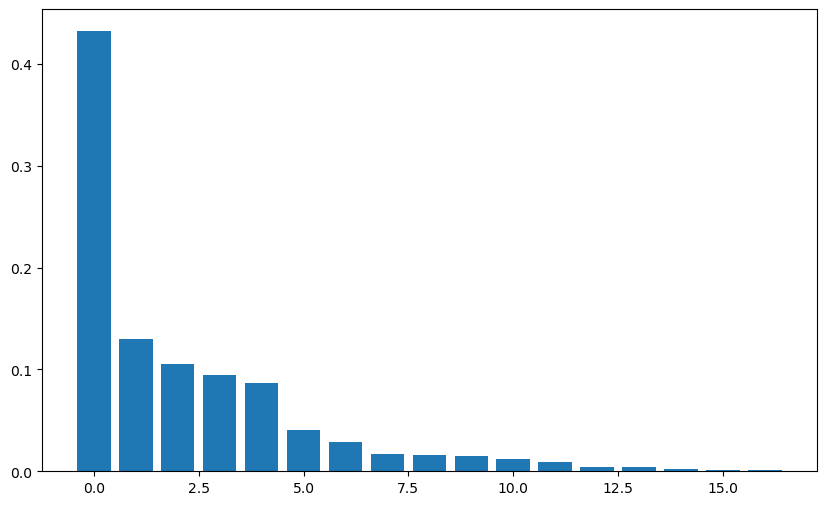

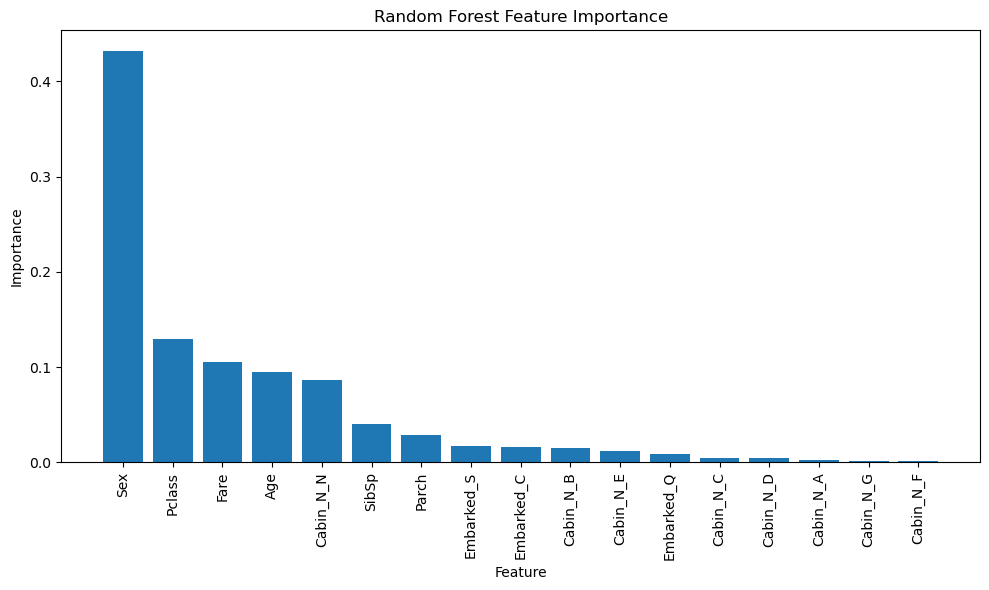

In [121]:
feature_importances = Randomf.feature_importances_
feature_names = x.columns

indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[indices]
sorted_feature_names = feature_names[indices]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), sorted_feature_importances)
plt.xticks(range(len(feature_importances)), sorted_feature_names, rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()

In [137]:
from sklearn import tree
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)

tree.plot_tree(Randomf.estimators_[0],
               feature_names = feature_names, 
               #class_names=cn,
               filled = True);

fig.savefig('./rf_individualtree.png')
